In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure, subplot, plot, title, legend, xlabel, ylabel, show,hist
import matplotlib.pyplot as plt
from scipy.linalg import svd
import sklearn.linear_model as lm
from scipy.io import loadmat

In [2]:
from matplotlib.pylab import (
    figure,
    semilogx,
    loglog,
    xlabel,
    ylabel,
    legend,
    title,
    subplot,
    show,
    grid,
)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
import sys

sys.path.append("./Tools")

from toolbox_02450 import rlr_validate

In [3]:
filename = "../MyData/HTRU_2.csv"
df = pd.read_csv(filename)

raw_data = df.values

cols = range(0, 9)
X = raw_data[:, cols]
# Column of platelets has to be divided with 1000,mistake in data

attributeNames = np.asarray(df.columns[cols])

classLabels = raw_data[:, -1]  # -1 takes the last column

classNames = np.unique(classLabels)

classDict = dict(zip(classNames, range(len(classNames))))

y = np.array([classDict[cl] for cl in classLabels])

N, M = X.shape



C = len(classNames)

classDict = dict(zip(range(1,8), classNames))


In [4]:
mean = X.mean()
std = X.std()

# Normalize our data
#Subtracting the median and dividing by the standard deviation
X = (X - mean) / std


[1]


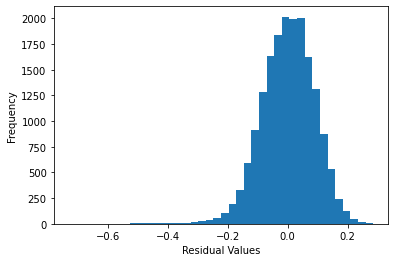

In [5]:
condition = (attributeNames == 'Profile_stdev')  # Example condition
PK_idx = np.where(condition)[0]
print(PK_idx)
# keepin as y the column that we are going to apply regression on
y = X[:,PK_idx]

# Keeping the columns except the one that we are going to apply regression on
X_cols = list(range(0, PK_idx[0])) + list(range(PK_idx[0] + 1, len(attributeNames)))

X = X[:,X_cols]

# Fit ordinary least squares regression model
model = lm.LinearRegression()
model.fit(X,y)

# Predict y-in our case Profile_kurtosis
y_est = model.predict(X)
residual = y_est-y

# Display scatter plot
figure()
# subplot(2,1,1)
# plot(y, y_est, '.')
# xlabel('Profile_kurtosis (true)'); ylabel('Profile_kurtosis (estimated)');
# subplot(2,1,2)

plt.hist(residual, bins=40)
plt.xlabel('Residual Values')
plt.ylabel('Frequency')
plt.show()



In [6]:
#REGULARIZATION PART 
mat_data = loadmat('../MyData/HTRU_2.mat')
X = mat_data['X']

y = X[:, 1]
X = X[:, [i for i in range(X.shape[1]) if i != 1]]


#y = mat_data['y'].squeeze()
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
N, M = X.shape


In [7]:
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

In [8]:
K = 10
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
#lambdas = np.power(10.0, range(-2, 4))
lambdas = np.logspace(-1, 1.5, 20);

In [9]:
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

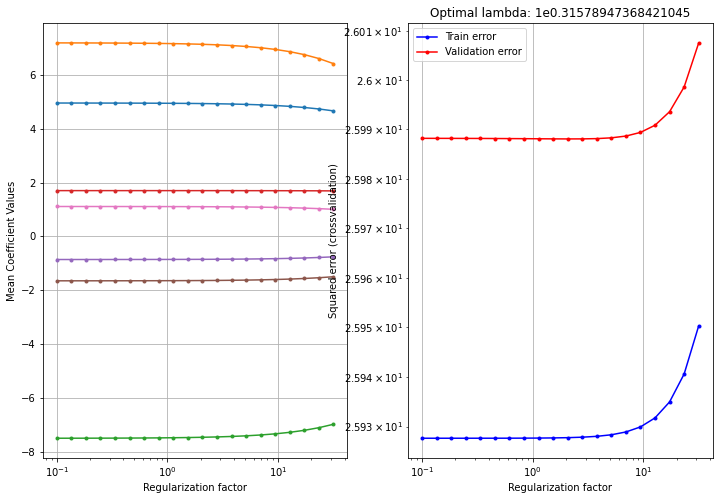

In [10]:
k=0
#This loop iterates through the training and test partitions created by cross-validation (CV).
#For each iteration, train_index and test_index contain the indexes of the instances to be used in the training set and test set for the current fold.
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold. 
    #We train the model on the training data and evaluate the performance of the trained model on the test data.
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    #The rlr_validate function is called to estimate the validation error and select the optimal lambda value for ridge regression.
    #Results are stored in several variables, including:
    # - opt_val_err (minimum validation error),
    # - opt_lambda (optimal lambda value),
    # - mean_w_vs_lambda (map of coefficients as a function of lambda),
    # - train_err_vs_lambda (training error as a function of lambda)
    # - test_err_vs_lambda (test error as a function of lambda).
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:

        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()
    

    k+=1

show()

In [11]:
#initializing arrays for baseline model
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))


In [12]:
k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )

    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )


    k += 1

[48.50706585]
[46.14513557]
[46.28670736]
[53.01327551]
[48.69939507]
[44.52470154]
[46.94211407]
[40.57346621]
[46.38589202]
[47.05800609]
